### Boilerplate code - llm initiation

In [39]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv

load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

google_llm = ChatGoogleGenerativeAI(
    temperature=0, 
    model="gemini-2.5-flash", 
    api_key=google_api_key,
    max_tokens=200
)

openai_llm = ChatOpenAI(
    temperature=0, 
    model="gpt-4", 
    api_key=openai_api_key
)

google_llm.invoke("Hello")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b02f5-1946-7f23-b5ee-33ca2221a0bb-0', usage_metadata={'input_tokens': 2, 'output_tokens': 43, 'total_tokens': 45, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 34}})

### Nodes, Edges and State

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    graph_state: str

def node_1(state):
    print("node__1")
    return {"graph_state": state["graph_state"] + "I am"}

def node_2(state: State) -> State:
    print("node__2")
    return {"graph_state": state["graph_state"] + " happy."}

def node_3(state: State) -> State:
    print("node__3")
    return {"graph_state": state["graph_state"] + " sad."}

def node_4(state: State) -> State:
    print("node__4")
    return {"graph_state": state["graph_state"] + " neutral."}


import random
from typing import Literal
def decide_mood(state) -> Literal["node_2", "node_3", "node_4"]:
    user_input = state['graph_state']
    ran = random.random()
    if ran < 0.3:
        return "node_2"
    if ran < 0.6:
        return "node_3"
    if ran < 1:
        return "node_4"


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)


# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)
builder.add_edge("node_4", END)

graph = builder.compile()

graph.invoke({"graph_state": "Hi, I am Praveen. "})

from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))



##### Looping the same node

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    graph_state: str
    num: int

num = 0

def node_1(state):
    print("node__1")
    state["num"] = state.get("num", 0) + 1 # Updating it just in function won't work. Return it as a state.
    num = state.get("num")
    print(state['graph_state'])
    return {"graph_state": state["graph_state"] + f" {num}", "num": num} 

from typing import Literal
def should_continue(state) -> Literal["node_1", "__end__"]:
    if state.get("num", 0) >= 5:
        return "__end__"
    return "node_1"


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)


# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", should_continue)

graph = builder.compile()

graph.invoke({"graph_state": "Hi, I am Praveen. "})

from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))



## Message state

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="Hi, there!", name="AI"), HumanMessage(content="Hello AI!", name="Human"), AIMessage(content="How can i help you?", name="AI"), HumanMessage(content="Why are you angry at me?", name="Human")]

google_llm.invoke(messages)

In [ ]:
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages: list[AnyMessage] # AIMessage(Role is assistant), HumanMessage(Role is human automatically)

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Intro on add_messages

In [ ]:
from langgraph.graph.message import add_messages

data1 = [{"role": "human", "content": "test"}] # role and content are must keys
data2 = [{"role": "ai", "content": "test2"}]

add_messages(data1, data2)

##### Chain - Traditional Langchain way

In [ ]:
from langchain_core.prompt import ChatPromptTemplate
from langchain_core.output_parser import StrOutputParser

prompt = ChatPromptTemplate.from_template("You are a helpful assistant. Answer this in 1 line {input}")
llm = google_llm
output_parser = StrOutputParser()

chain = prompt | llm | output_parser

chain.invoke({"input": "Who is virat kohli?"})

'Virat Kohli is a celebrated Indian international cricketer, widely regarded as one of the greatest batsmen.'

##### Chain - Mimick the above in Langgraph way

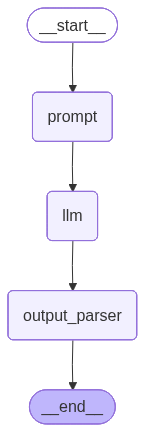

In [42]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

def prompt():
    pass

def llm():
    pass

def output_parser():
    pass

class State(TypedDict):
    prompt: str
    llm: str
    output_parser: str

builder = StateGraph(State)

builder.add_node("prompt", prompt)
builder.add_node("llm", llm)
builder.add_node("output_parser", output_parser)

builder.add_edge(START, "prompt")
builder.add_edge("prompt", "llm")
builder.add_edge("llm", "output_parser")
builder.add_edge("output_parser", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))